In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime

train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
id_test = test.id
train.sample(3)
# Any results you write to the current directory are saved as output.

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
10271,10274,2013-09-04,90,61.0,3.0,6.0,2.0,1947.0,4.0,9.0,...,25,4,0,9,31,1,10,67,9,8800000
25714,25717,2014-12-03,93,NaN,2.0,0.0,1.0,NaN,3.0,0.0,...,2,2,0,3,13,0,0,6,3,6935950
9894,9897,2013-08-17,32,18.0,6.0,NaN,NaN,NaN,NaN,NaN,...,6,2,0,5,10,0,2,41,7,1000000


In [42]:
y_train = train["price_doc"]
x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)

#can't merge train with test because the kernel run for very long time

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True) 

In [43]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

[0]	train-rmse:8.20593e+06	test-rmse:8.20865e+06
[50]	train-rmse:2.52775e+06	test-rmse:2.89073e+06
[100]	train-rmse:2.19272e+06	test-rmse:2.70565e+06
[150]	train-rmse:2.07303e+06	test-rmse:2.6703e+06
[200]	train-rmse:1.98557e+06	test-rmse:2.64838e+06
[250]	train-rmse:1.91812e+06	test-rmse:2.63979e+06
[300]	train-rmse:1.85714e+06	test-rmse:2.63207e+06
[350]	train-rmse:1.8054e+06	test-rmse:2.62911e+06
[400]	train-rmse:1.75614e+06	test-rmse:2.62691e+06


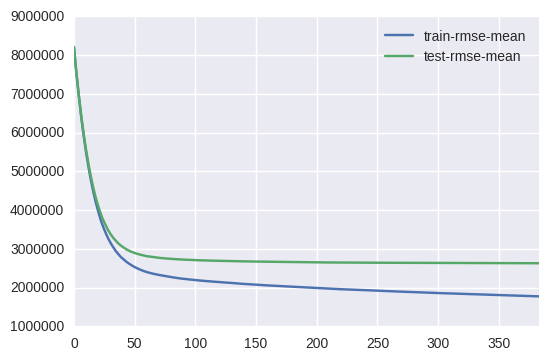

In [44]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [45]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

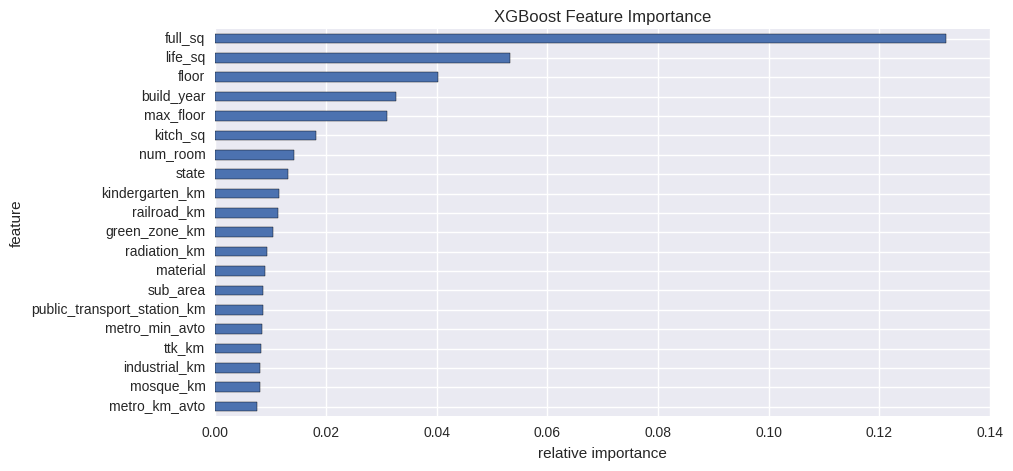

In [58]:
import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [47]:
y_predict = model.predict(dtest)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
output.to_csv('xgbSub.csv', index=False)

In [48]:
print output.describe()

                 id     price_doc
count   7662.000000  7.662000e+03
mean   34304.500000  7.498405e+06
std     2211.973214  3.887395e+06
min    30474.000000  1.707083e+06
25%    32389.250000  5.329088e+06
50%    34304.500000  6.577599e+06
75%    36219.750000  8.545390e+06
max    38135.000000  6.584807e+07


# log(predict)

In [55]:
ylog_train = np.log(y_train)
dtrain = xgb.DMatrix(x_train, ylog_train)
dtest = xgb.DMatrix(x_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)

[0]	train-rmse:14.3666	test-rmse:14.3667
[50]	train-rmse:1.20179	test-rmse:1.20756
[100]	train-rmse:0.444425	test-rmse:0.474877
[150]	train-rmse:0.419824	test-rmse:0.46391
[200]	train-rmse:0.406785	test-rmse:0.462948
[250]	train-rmse:0.395627	test-rmse:0.462872


In [59]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

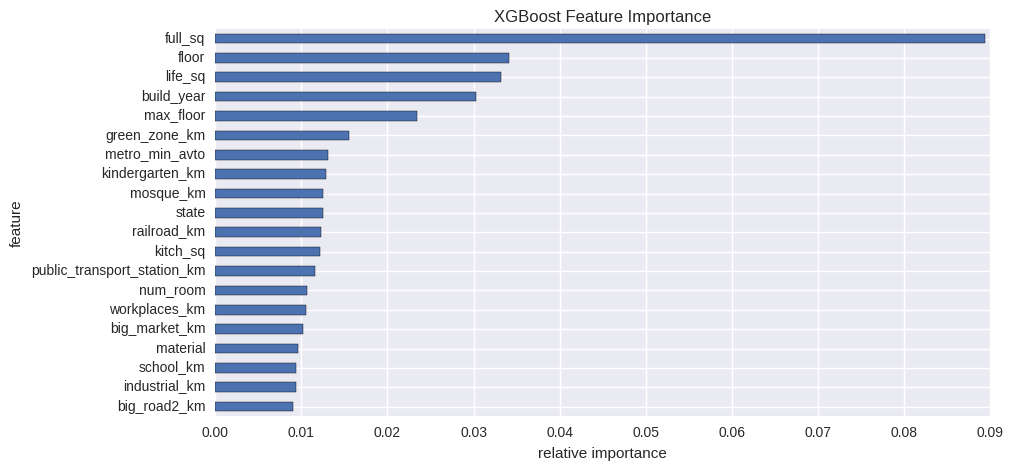

In [60]:
import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [65]:
ylog_predict = model.predict(dtest)
output_log = pd.DataFrame({'id': id_test, 'price_doc': np.exp(ylog_predict)})
#output.to_csv('xgbSub.csv', index=False)
#print output.describe(), output_log.describe()

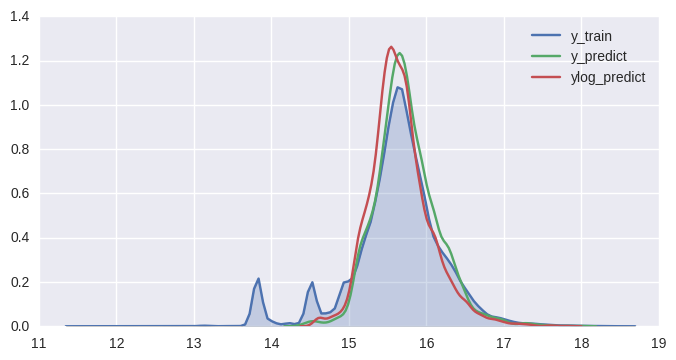

In [71]:
plt.figure(figsize=(8,4))
sns.kdeplot(np.log(y_train), shade=True, label="y_train")
sns.kdeplot(np.log(y_predict), shade=False, label="y_predict")
sns.kdeplot(ylog_predict, shade=False, label="ylog_predict")
plt.legend(loc='best');

In [73]:
it = np.log(y_train) < 15
it.sum()

3444

# Dummy matrix

In [119]:
y_train = train["price_doc"]
x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)
X = pd.concat([x_train, x_test], axis=0)
num_train = x_train.shape[0]
 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

object_col = []
for c in X.columns:
    if X[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X[c].values)) 
        yy = lbl.transform(list(X[c].values))
        X[c] = lbl.transform(list(X[c].values))
                
        onehot_encoder = OneHotEncoder(sparse=False)
        dummy = pd.DataFrame(onehot_encoder.fit_transform(yy.reshape(X.shape[0],1)).astype(int),
                     columns=[c+"_"+str(i) for i in range(0,max(yy)+1)])
        X = pd.concat([X.reset_index(), dummy], axis=1)
        X.set_index('index', inplace=True)
        
        object_col.append(c)

       
print object_col

['product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology']


In [120]:
print X.shape
print x_test.shape
#x_train = x_train.drop(object_col, axis=1)
#x_test = x_test.drop(object_col, axis=1)
#print x_train.shape
#print x_test.shape
#print x_train["sub_area"].max()
#print x_test["sub_area"].max()

(38133, 467)
(7662, 289)


[0]	train-rmse:8.20627e+06	test-rmse:8.21108e+06
[50]	train-rmse:2.52495e+06	test-rmse:2.88661e+06
[100]	train-rmse:2.19423e+06	test-rmse:2.70548e+06
[150]	train-rmse:2.07693e+06	test-rmse:2.67164e+06
[200]	train-rmse:1.99081e+06	test-rmse:2.65083e+06
[250]	train-rmse:1.92251e+06	test-rmse:2.64224e+06
[300]	train-rmse:1.86477e+06	test-rmse:2.63717e+06
[350]	train-rmse:1.81098e+06	test-rmse:2.63358e+06
[400]	train-rmse:1.7582e+06	test-rmse:2.6292e+06
[450]	train-rmse:1.71319e+06	test-rmse:2.62785e+06


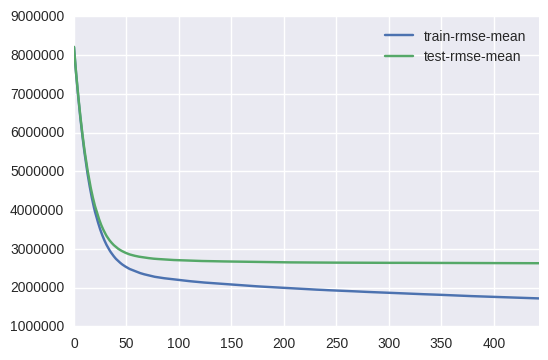

In [121]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X[:num_train], y_train)
dtest = xgb.DMatrix(X[num_train:])

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

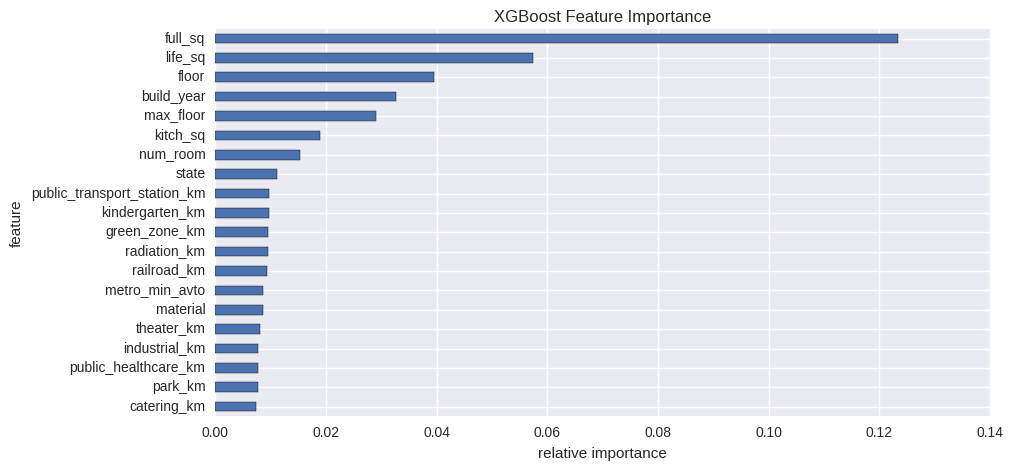

In [122]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [139]:
#y_predict_dummy = model.predict(dtest)
#output_dummy = pd.DataFrame({'id': id_test, 'price_doc': y_predict_dummy})
output_dummy.to_csv('xgb_dummy.csv', index=False)

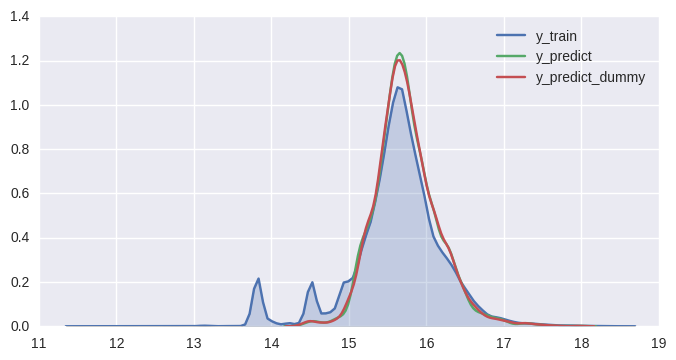

In [125]:
plt.figure(figsize=(8,4))
sns.kdeplot(np.log(y_train), shade=True, label="y_train")
sns.kdeplot(np.log(y_predict), shade=False, label="y_predict")
#sns.kdeplot(ylog_predict, shade=False, label="ylog_predict")
sns.kdeplot(np.log(y_predict_dummy), shade=False, label="y_predict_dummy")
plt.legend(loc='best');

In [128]:
print output.describe(), output_dummy.describe()

                 id     price_doc
count   7662.000000  7.662000e+03
mean   34304.500000  7.498405e+06
std     2211.973214  3.887395e+06
min    30474.000000  1.707083e+06
25%    32389.250000  5.329088e+06
50%    34304.500000  6.577599e+06
75%    36219.750000  8.545390e+06
max    38135.000000  6.584807e+07                  id    price_doc
count   7662.000000      7662.00
mean   34304.500000   7514529.50
std     2211.973214   3887834.50
min    30474.000000   1747414.75
25%    32389.250000   5310514.50
50%    34304.500000   6595281.50
75%    36219.750000   8571239.50
max    38135.000000  63967120.00


## only dummy

In [129]:
print X.shape
X = X.drop(object_col, axis=1)
print X.shape

(38133, 467)
(38133, 452)


[0]	train-rmse:8.20632e+06	test-rmse:8.2115e+06
[50]	train-rmse:2.52097e+06	test-rmse:2.89417e+06
[100]	train-rmse:2.19292e+06	test-rmse:2.71549e+06
[150]	train-rmse:2.08115e+06	test-rmse:2.67768e+06
[200]	train-rmse:1.99464e+06	test-rmse:2.66006e+06
[250]	train-rmse:1.92569e+06	test-rmse:2.64872e+06
[300]	train-rmse:1.86248e+06	test-rmse:2.64299e+06


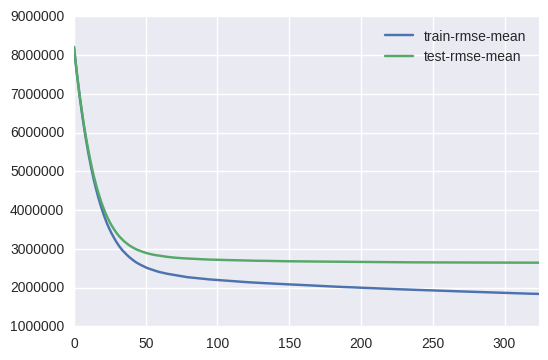

In [130]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X[:num_train], y_train)
dtest = xgb.DMatrix(X[num_train:])

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

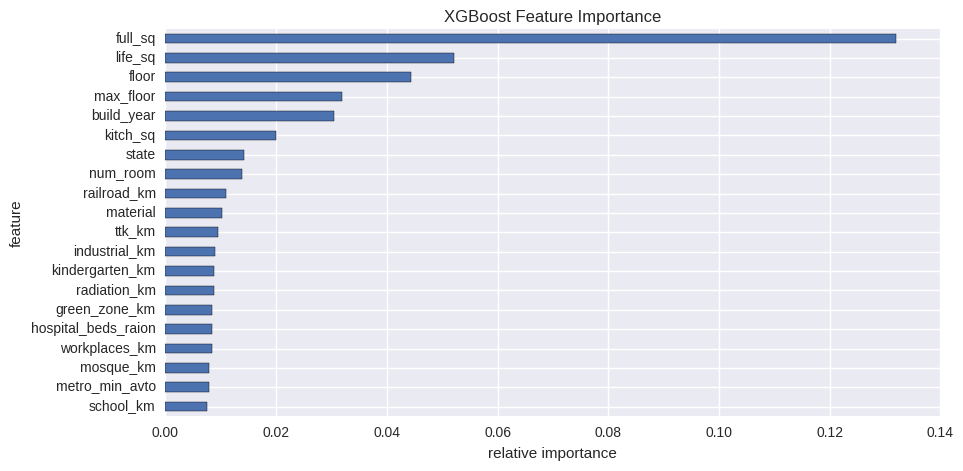

In [131]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

import operator
importance = model.get_score()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df[-20:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [140]:
#y_predict_dummy2 = model.predict(dtest)
#output_dummy2 = pd.DataFrame({'id': id_test, 'price_doc': y_predict_dummy2})
output_dummy2.to_csv('xgb_dummy2.csv', index=False)

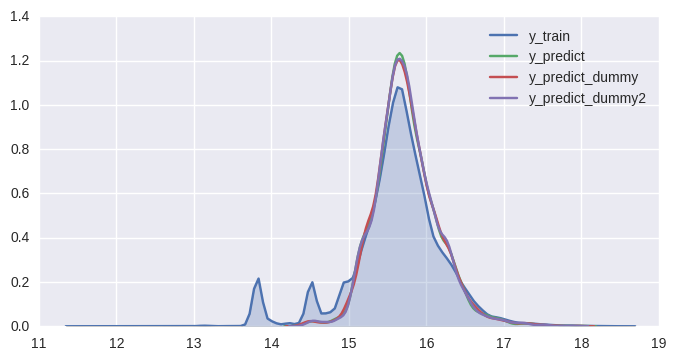

In [136]:
plt.figure(figsize=(8,4))
sns.kdeplot(np.log(y_train), shade=True, label="y_train")
sns.kdeplot(np.log(y_predict), shade=False, label="y_predict")
#sns.kdeplot(ylog_predict, shade=False, label="ylog_predict")
sns.kdeplot(np.log(y_predict_dummy), shade=False, label="y_predict_dummy")
sns.kdeplot(np.log(y_predict_dummy2), shade=False, label="y_predict_dummy2")
plt.legend(loc='best');

In [137]:
print output.describe(), output_dummy.describe(), output_dummy2.describe()

                 id     price_doc
count   7662.000000  7.662000e+03
mean   34304.500000  7.498405e+06
std     2211.973214  3.887395e+06
min    30474.000000  1.707083e+06
25%    32389.250000  5.329088e+06
50%    34304.500000  6.577599e+06
75%    36219.750000  8.545390e+06
max    38135.000000  6.584807e+07                  id    price_doc
count   7662.000000      7662.00
mean   34304.500000   7514529.50
std     2211.973214   3887834.50
min    30474.000000   1747414.75
25%    32389.250000   5310514.50
50%    34304.500000   6595281.50
75%    36219.750000   8571239.50
max    38135.000000  63967120.00                  id    price_doc
count   7662.000000      7662.00
mean   34304.500000   7504945.00
std     2211.973214   3825187.00
min    30474.000000   1816554.00
25%    32389.250000   5341727.25
50%    34304.500000   6620640.25
75%    36219.750000   8556118.50
max    38135.000000  59618732.00
